In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import multiprocessing  as mp
from itertools import product


from keras.models import Sequential,Model
from keras.layers import *#Dense, Input, Concatenate, Lambda,LSTM,Dropout,Layer,Flatten
from keras.layers import ConvLSTM2D,BatchNormalization,TimeDistributed,MaxPooling3D
from keras.optimizers import RMSprop, Adam
from keras import optimizers
from keras.utils.vis_utils import plot_model
import keras.losses as kl
import pydot

from keras import optimizers
import keras
from scipy import stats
import pickle

import tensorflow as tf

import sys
import warnings
import os
#from tqdm import tqdm
os.chdir('/gneven/Desktop/ETH/Sem2/Projeckt/Pyhton/')
from scipy.interpolate import UnivariateSpline
from functions import * 
import keras.backend.tensorflow_backend as tfback

idx = pd.IndexSlice

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

In [6]:
FrameT = pd.read_pickle(os.getcwd()+'/DataPickles//BusFrameT.pickle')

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=15, 
                        inter_op_parallelism_threads=15, 
                        allow_soft_placement=True,
                        device_count = {'CPU': 15})

session = tf.compat.v1.Session(config=config)

FrameT[np.isnan(FrameT)] = 0
FrameT[FrameT>1200] = 0
FrameT[FrameT<-1200] = 0
#FrameT = FrameT[:2,:,:,:,:]
meanF = np.mean(FrameT)
FrameT -= meanF
std = np.std(abs(FrameT))
FrameT /= std 

out_dt = 10
in_dt = 30
dt = 30

starttime = 7*3600
endtime = 9*3600

# 6.5 -- 10.5
in_data = [6.5*3600,10.5*3600]

diff = int((starttime- in_data[0])/dt)


input_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),in_dt,1,FrameT.shape[3],FrameT.shape[4]))#FrameT.shape[2]
output_bus = np.ndarray((FrameT.shape[0],int((endtime-out_dt-starttime)/dt),out_dt,FrameT.shape[3],FrameT.shape[4]))
for i in range(int((endtime-out_dt-starttime)/dt)):
    input_bus[:,i,:,:,:,:] = FrameT[:,(diff+i-in_dt):(diff+i),2:,:,:]
    output_bus[:,i,:,:,:] = FrameT[:,(diff+i):(diff+i+out_dt),2,:,:]

mean_allday = np.mean(output_bus[:,:,:,:,0],axis = (0))
vali = input_bus[[0,6,12,18,24,29,34],:,:,:,:]
valo = output_bus[[0,6,12,18,24,29,34],:,:,:,:]
input_bus = np.delete(input_bus,[0,6,12,18,24,29,34], axis = 0)
output_bus = np.delete(output_bus,[0,6,12,18,24,29,34], axis = 0)

batch_size =input_bus.shape[1]
print(batch_size)

input_bus = input_bus.reshape(input_bus.shape[0]*input_bus.shape[1],input_bus.shape[2],input_bus.shape[3],input_bus.shape[4],input_bus.shape[5])
output_bus = output_bus.reshape(output_bus.shape[0]*output_bus.shape[1],output_bus.shape[2],output_bus.shape[3],output_bus.shape[4])
valoday = valo
validay = vali

vali = vali.reshape(vali.shape[0]*vali.shape[1],vali.shape[2],vali.shape[3],vali.shape[4],vali.shape[5])
valo = valo.reshape(valo.shape[0]*valo.shape[1],valo.shape[2],valo.shape[3],valo.shape[4])

output_bus = np.expand_dims(output_bus,axis = 4)
valo = np.expand_dims(valo,axis = 4)

mean_allday = np.resize(mean_allday,(valoday.shape[0]*mean_allday.shape[0],mean_allday.shape[1],mean_allday.shape[2]))

239


In [10]:
with open(os.getcwd()+'/DataPickles/step108_all.pickle', "rb") as f:
    predicty = pickle.load(f)
    hist = pickle.load(f)
    model = pickle.load(f)
with open(os.getcwd()+'/DataPickles/Data_line.pickle',"rb") as p:
    data_line = pickle.load(p)

<IPython.core.display.Javascript object>


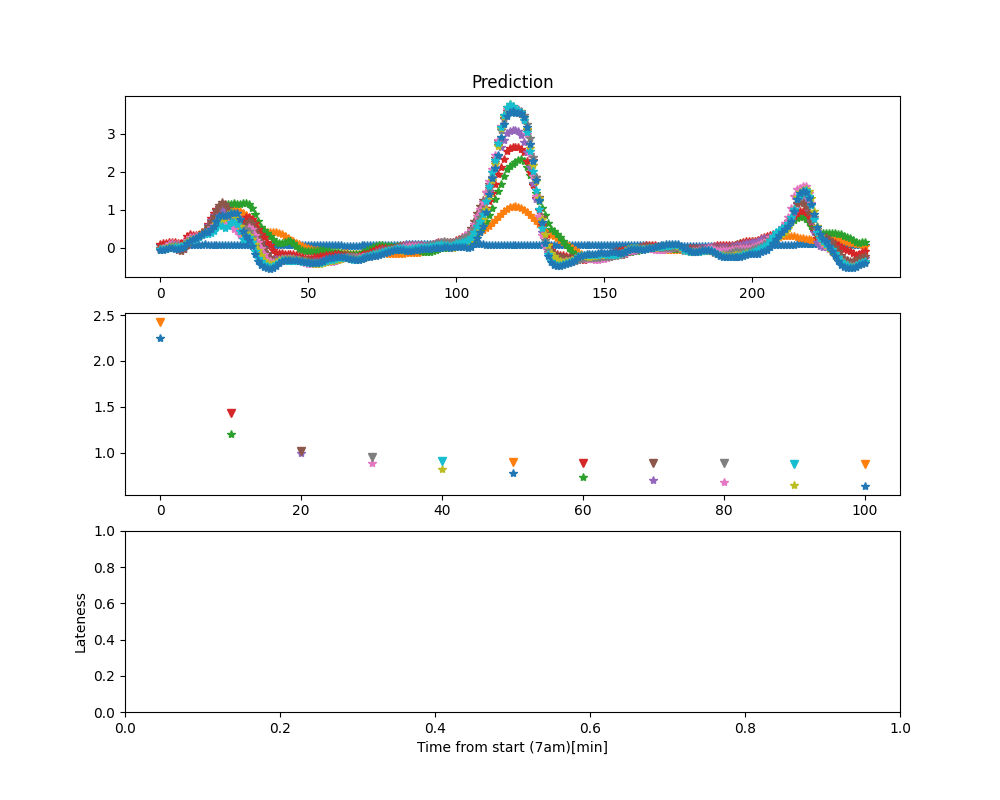

NameError: name 'predict_y' is not defined

In [11]:


%matplotlib notebook
which = 1
#model32 = model
#predicty32 = predicty
#hist32 = hist

fig = plt.figure(3,figsize = (10,8))
ax1 = plt.subplot(3,1,1)
plt.title('Prediction')
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)
plt.xlabel('Time from start (7am)[min]')
plt.ylabel('Lateness')
for i in range(len(predicty)):
    ax1.plot(predicty[i][:,1,which,0,0],'*',label = 'Epoch %i' %i)
    ax2.plot(10*i,hist[10*i].history['loss'],'*')
    ax2.plot(10*i,hist[10*i].history['val_loss'],'v')
ax3.plot(predict_y[:239,9,which,0,0]*std + meanF,'*',label = 'Epoch %i' %i)
ax2.set_yscale('log')
ax3.plot(valo[:239,9,which,0,0]*std + meanF)
ax3.plot(mean_allday[:239,9,which]*std + meanF,'v')


ax2.set(ylabel= 'Loss',xlabel = 'Epochs',title = 'Loss')

ax1.set(ylabel= 'Lateness',xlabel = 'Time from start (7am)[min]')

ax3.set(title = 'Prediction for one day for one bus')

ax2.legend(['Train','Validation'])
ax3.legend(['LSTM','Real','Mean'])

fig.subplots_adjust(hspace = 0.5) 

In [16]:
hist[30].history['val_loss']

[0.9551815390586853]

<IPython.core.display.Javascript object>


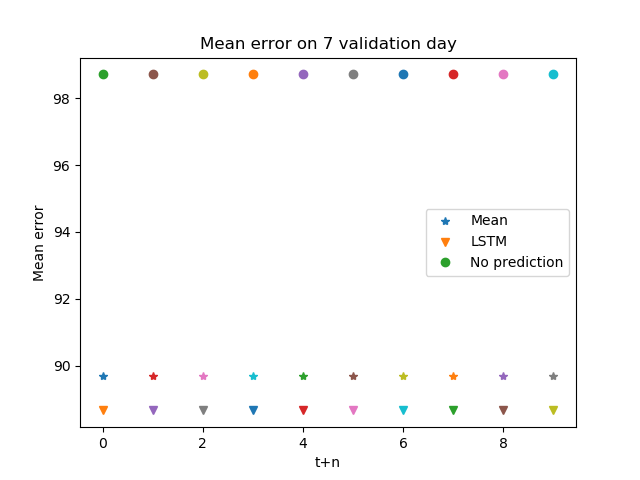

Absolute error for day 1 t+1, mean : 89.68137753631174
Absolute error for day 1  t+1, LSTM : 88.65934708514277
Absolute error for day 1 t+2, mean : 89.68137753631174
Absolute error for day 1  t+2, LSTM : 88.65934708514277
Absolute error for day 1 t+3, mean : 89.68137753631174
Absolute error for day 1  t+3, LSTM : 88.65934708514277
Absolute error for day 1 t+4, mean : 89.68137753631174
Absolute error for day 1  t+4, LSTM : 88.65934708514277
Absolute error for day 1 t+5, mean : 89.68137753631174
Absolute error for day 1  t+5, LSTM : 88.65934708514277
Absolute error for day 1 t+6, mean : 89.68137753631174
Absolute error for day 1  t+6, LSTM : 88.65934708514277
Absolute error for day 1 t+7, mean : 89.68137753631174
Absolute error for day 1  t+7, LSTM : 88.65934708514277
Absolute error for day 1 t+8, mean : 89.68137753631174
Absolute error for day 1  t+8, LSTM : 88.65934708514277
Absolute error for day 1 t+9, mean : 89.68137753631174
Absolute error for day 1  t+9, LSTM : 88.65934708514277
A

[Text(0, 0.5, 'Mean error'),
 Text(0.5, 0, 't+n'),
 Text(0.5, 1.0, 'Mean error on 7 validation day')]

In [129]:
%matplotlib notebook
fig = plt.figure(6)
ax = fig.gca()
i = 333



for t in range(10):
    print('Absolute error for day 1 t+%i, mean :' %(t+1),np.mean(abs(mean_allday*std + meanF-valo[:,:,:,0,0]*std + meanF)))
    print('Absolute error for day 1  t+%i, LSTM :' %(t+1),np.mean(abs(predict_y[:,:,:,0,0]*std + meanF-valo[:,:,:,0,0]*std + meanF)))
    ax.plot(t,np.mean(abs(mean_allday*std + meanF-valo[:,:,:,0,0]*std + meanF)),'*')
    ax.plot(t,np.mean(abs(predict_y[:,:,:,0,0]*std + meanF-valo[:,:,:,0,0]*std + meanF)),'v')
    ax.plot(t,np.mean(abs(valo[:,:,:,0,0]*std + meanF)),'o')
    
plt.legend(['Mean','LSTM','No prediction'])

ax.set(ylabel= 'Mean abs error',xlabel = 't+n',title = 'Mean error on 7 validation day')




<IPython.core.display.Javascript object>


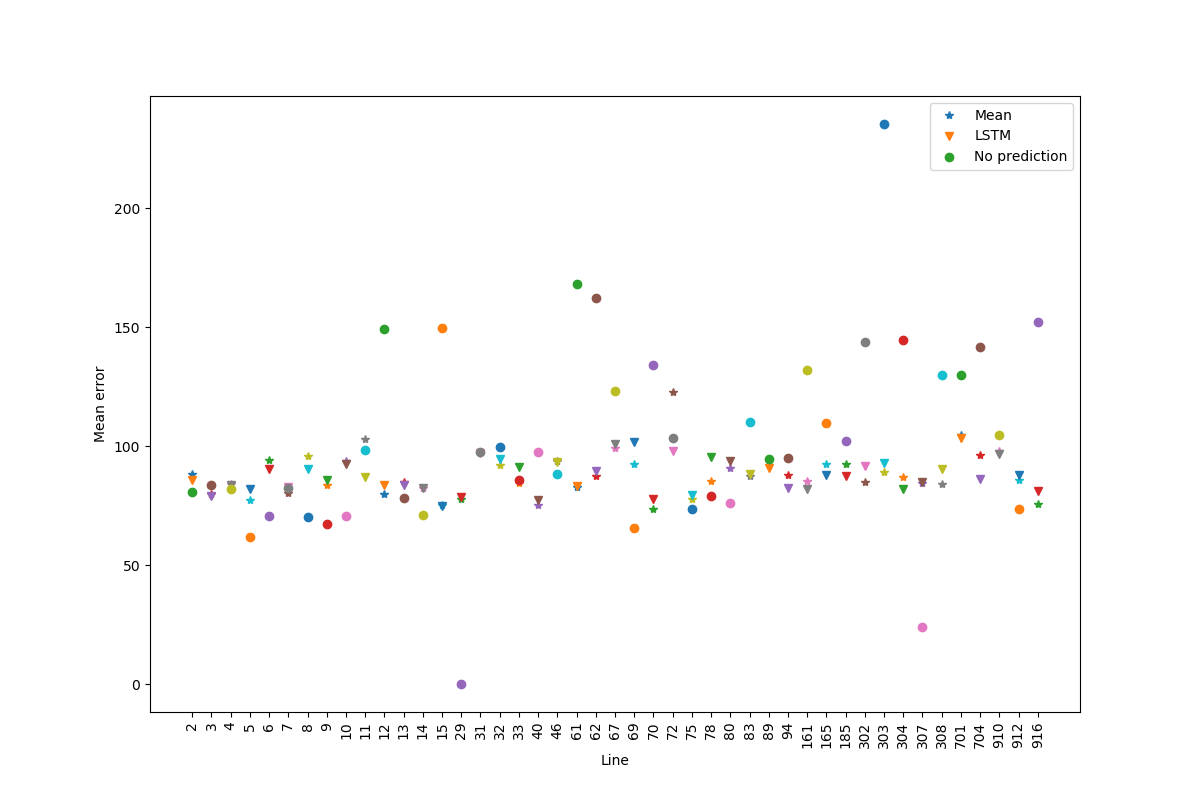

[Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '29'),
 Text(0, 0, '31'),
 Text(0, 0, '32'),
 Text(0, 0, '33'),
 Text(0, 0, '40'),
 Text(0, 0, '46'),
 Text(0, 0, '61'),
 Text(0, 0, '62'),
 Text(0, 0, '67'),
 Text(0, 0, '69'),
 Text(0, 0, '70'),
 Text(0, 0, '72'),
 Text(0, 0, '75'),
 Text(0, 0, '78'),
 Text(0, 0, '80'),
 Text(0, 0, '83'),
 Text(0, 0, '89'),
 Text(0, 0, '94'),
 Text(0, 0, '161'),
 Text(0, 0, '165'),
 Text(0, 0, '185'),
 Text(0, 0, '302'),
 Text(0, 0, '303'),
 Text(0, 0, '304'),
 Text(0, 0, '307'),
 Text(0, 0, '308'),
 Text(0, 0, '701'),
 Text(0, 0, '704'),
 Text(0, 0, '910'),
 Text(0, 0, '912'),
 Text(0, 0, '916')]

In [128]:
%matplotlib notebook

line = np.floor(data_line/100)

fig = plt.figure(7,figsize = (12,8))
ax = fig.gca()
i = 333
t = 0
for l in np.unique(line):
    ax.plot(t,np.mean(abs(mean_allday[:,:,line == l]*std + meanF-valo[:,:,line == l,0,0]*std + meanF)),'*')
    ax.plot(t,np.mean(abs(predict_y[:,:,line == l,0,0]*std + meanF-valo[:,:,line == l,0,0]*std + meanF)) ,'v')
    ax.plot(t,np.mean(abs(valo[:,:,line == l,0,0]*std + meanF)) ,'o')
    t+= 1
    
plt.legend(['Mean','LSTM','No prediction'])

ax.set(ylabel= 'Mean error',xlabel = 'Line')

plt.xticks(range(len(np.unique(line))),rotation=90)
ax.set_xticklabels(np.unique(line).astype('int32'))

In [147]:
model.summary() 
vali[:239,:,:,:,:].shape

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 30, 1, 375, 1)     4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 30, 64, 375, 1)    83456     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 64, 375, 1)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 64, 375, 1)    4         
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 32, 375, 1)        61568     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 375, 1)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 375, 1)       

(239, 30, 1, 375, 1)

In [252]:
# outpu = np.empty((375,375))
toolbar_width = 40

sys.stdout.write("[%s]" % (" " * toolbar_width))
sys.stdout.flush()
sys.stdout.write("\b" * (toolbar_width+1)) # return to start of line, after '['
t1 = time.time()
for i in  range(240,375):
    inpu = np.zeros((239, 30, 1, 375, 1))

    inpu[:,:,:,i,:] = 1e10
    
    outpu[i,:] = np.sum(model.predict(inpu),axis = (0,1,3,4))
    sys.stdout.write(("["+l*"-" + ("%i"%i) + (toolbar_width-l-3)*" "+"]\r" ))
    sys.stdout.flush()
    if i%10 == 0:
        l += 1
sys.stdout.write("]\n")

inpu = np.zeros((239, 30, 1, 375, 1))
outpu0 = np.sum(model.predict(inpu),axis = (0,1,3,4))
print(t1-time.time())


]---------------------------------------374]-----------------------240            ]
-7007.623813867569


In [1]:
# with open('savefig.pickle','wb') as f:
#     pickle.dump(outpu,f)
#     pickle.dump(outpu0,f)
%matplotlib notebook

fig = plt.figure(20)
ax = fig.gca()
ax.imshow(outpu-outpu0)
# ax.plot(outpu[:3,:].T)

# test = model.predict(inpu)


NameError: name 'pickle' is not defined

<IPython.core.display.Javascript object>


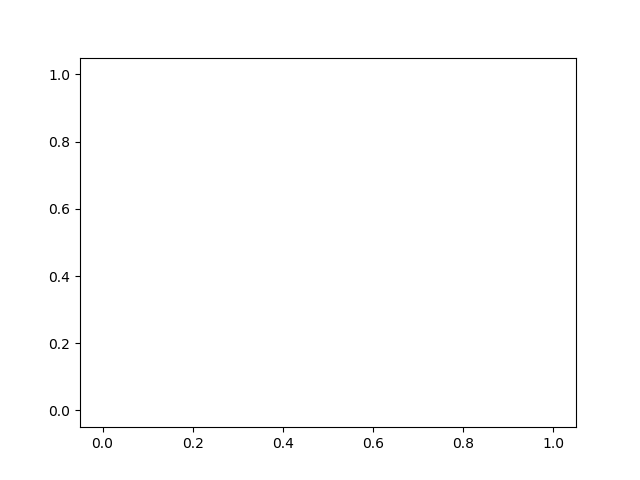

In [241]:
inpu = np.empty((239, 30, 1, 375, 1))
inpu[:] = np.NaN
inpu[:,:,:,0,:] = 1


fig = plt.figure(21)
ax = fig.gca()
# ax.imshow(outpu)
# ax.plot(outpu[0,:].T)
ax.plot(np.sum(test.T,axis = (0,1,3,4)))


In [247]:
outpu.shape

(375, 375)